In [3]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
import time
import matplotlib.pyplot as plt
from data_generation import generate_stock_dataframes
from train_model import grid_search

ImportError: cannot import name 'generate_stock_dataframes' from 'data_generation' (/home/str/eigene_programme/trader/data_generation.py)

In [2]:
# Alpaca API credentials
API_KEY = "PKY0AF1LLQM4SHJT290O"
API_SECRET = "GMP58HBD35EhHhNBJAK46tsEUp2S6Ab0o3LGE7mc"

In [3]:
BASE_URL = "https://paper-api.alpaca.markets"  # For paper trading

In [4]:
# Initialize the Alpaca API connection
api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL, api_version='v2')

In [5]:
APPLE_DATA = api.get_bars('AAPL', TimeFrame.Minute, limit=800).df

                  timestamp       l       i       o    r       p      o  \
0 2024-09-25 08:00:00+00:00  225.74  226.98  225.74  186  226.98  10143   
1 2024-09-25 08:01:00+00:00  226.00  226.00  225.51   92  225.51   2964   
2 2024-09-25 08:02:00+00:00  226.00  226.25  226.00   70  226.25   1266   
3 2024-09-25 08:03:00+00:00  226.36  226.36  226.36   55  226.36    644   
4 2024-09-25 08:04:00+00:00  226.06  226.06  226.06   63  226.06   1210   

            w  
0  226.092747  
1  225.772061  
2  226.162875  
3  226.334239  
4  226.092273  


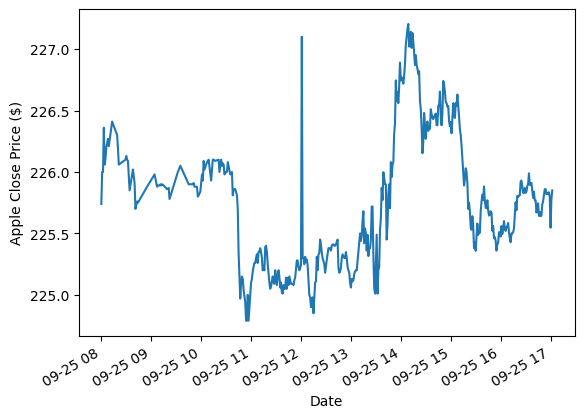

In [6]:
# Reformat data (drop multiindex, rename columns, reset index)
APPLE_DATA.columns = APPLE_DATA.columns.to_flat_index()
APPLE_DATA.columns = [x[1] for x in APPLE_DATA.columns]
APPLE_DATA.reset_index(inplace=True)
print(APPLE_DATA.head())

# Plot stock price data
plot = APPLE_DATA.plot(x="timestamp", y="l", legend=False)
plot.set_xlabel("Date")
plot.set_ylabel("Apple Close Price ($)")
plt.show()

In [25]:
# Stock to trade and thresholds
symbol = 'AAPL'
buy_price_threshold = 250.00  # Buy if price drops below this
sell_price_threshold = 170.00  # Sell if price goes above this

In [8]:
# Amount to trade
quantity = 10  # Number of shares to buy/sell

In [9]:
def get_stock_price(symbol):
    """Retrieve the current price of a stock."""
    barset = api.get_bars(symbol, TimeFrame.Minute, limit=1)
    stock_price = barset[0].c
    return stock_price

In [10]:
def submit_order(symbol, qty, side, order_type="market", time_in_force="gtc"):
    """Submit an order to buy or sell stock."""
    try:
        api.submit_order(
            symbol=symbol,
            qty=qty,
            side=side,
            type=order_type,
            time_in_force=time_in_force
        )
        print(f"Order submitted: {side} {qty} shares of {symbol}")
    except Exception as e:
        print(f"Failed to submit order: {e}")

In [23]:
def check_and_trade():
    """Check stock price and decide whether to buy or sell."""
    current_price = get_stock_price(symbol)
    print(f"Current price of {symbol}: ${current_price}")

    # Get the current position
    try:
        position = api.get_position(symbol)
        has_position = True
        current_qty = int(position.qty)
        print(f"Currently holding {current_qty} shares of {symbol}")
    except:
        print("EX")
        has_position = False
        current_qty = 0

    print(current_price)
    print(buy_price_threshold)
    print(has_position)
    # Buy condition
    if current_price < buy_price_threshold and not has_position:
        print(f"Price is below {buy_price_threshold}, buying {quantity} shares of {symbol}")
        submit_order(symbol, quantity, 'buy')

    # Sell condition
    elif current_price > sell_price_threshold and has_position:
        print(f"Price is above {sell_price_threshold}, selling {current_qty} shares of {symbol}")
        submit_order(symbol, current_qty, 'sell')

In [26]:
if __name__ == '__main__':
    while True:
        check_and_trade()
        time.sleep(60)  # Wait 1 minute between checks

Current price of AAPL: $225.74
EX
225.74
250.0
False
Price is below 250.0, buying 10 shares of AAPL
Order submitted: buy 10 shares of AAPL
Current price of AAPL: $225.74
Currently holding 10 shares of AAPL
225.74
250.0
True
Price is above 170.0, selling 10 shares of AAPL
Order submitted: sell 10 shares of AAPL


KeyboardInterrupt: 